In [1]:
import pandas as pd
import os
import numpy
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import sys
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer
import seaborn as sns, numpy as np
from sklearn.preprocessing import power_transform
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn import linear_model


In [2]:
numpy.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_columns', 500)
data = pd.read_csv("/Users/ajinkya.parkar@ibm.com/Documents/deep/House price prediction/data/train.csv")
data_test = pd.read_csv("/Users/ajinkya.parkar@ibm.com/Documents/deep/House price prediction/data/test.csv")

# Prepare data by removing null columns and converting category to int

In [3]:
def prepareData(data):
    data = data
    data = data.fillna("NA")
    for col_name in data.columns:
        if(data[col_name].dtype == 'object'):
            data[col_name]= data[col_name].astype('category')
            data[col_name] = data[col_name].cat.codes


    return data

In [4]:
Train_data = prepareData(data)
Test_data = prepareData(data_test)

# Check for outliers

MSSubClass


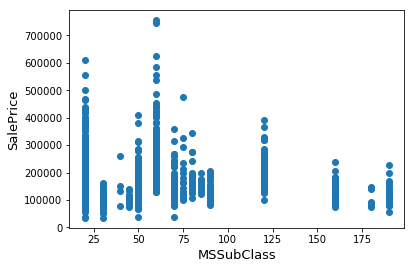

MSZoning


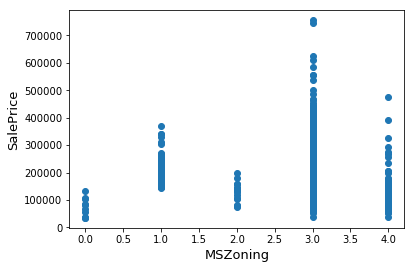

LotFrontage


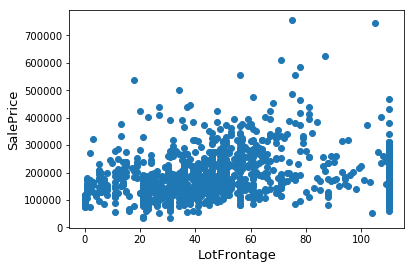

LotArea


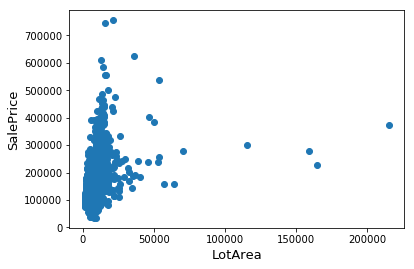

Street


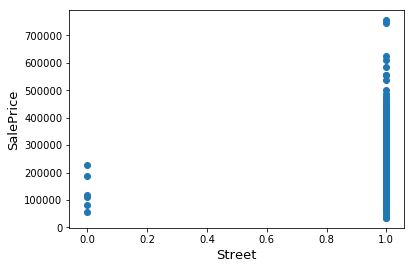

Alley


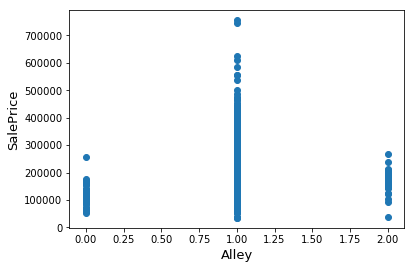

LotShape


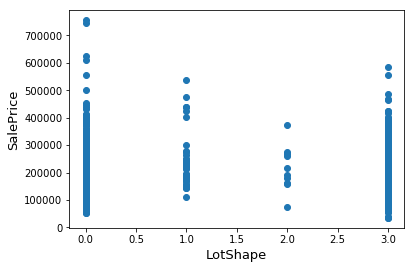

LandContour


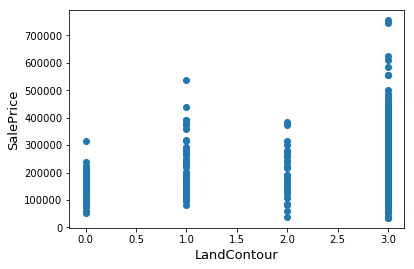

Utilities


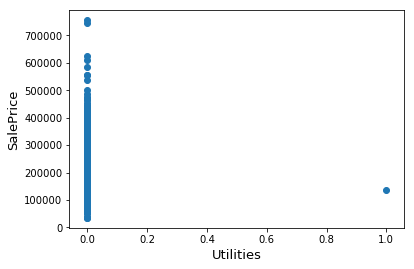

LotConfig


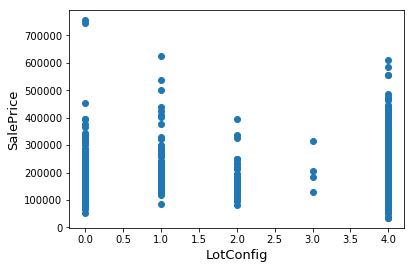

LandSlope


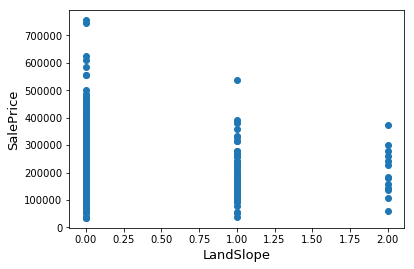

Neighborhood


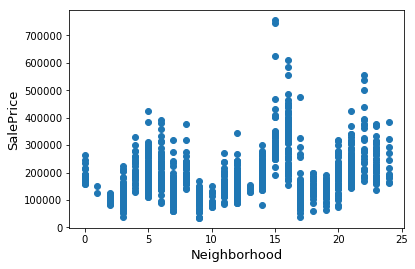

Condition1


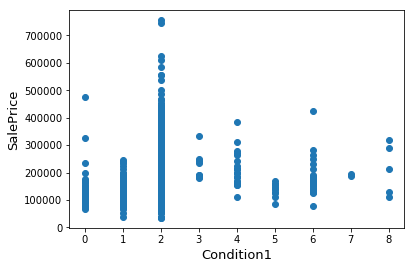

Condition2


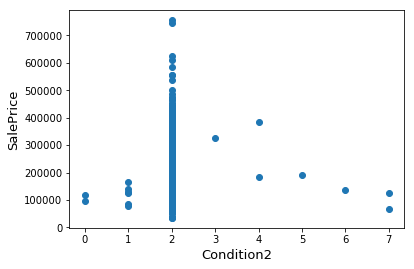

BldgType


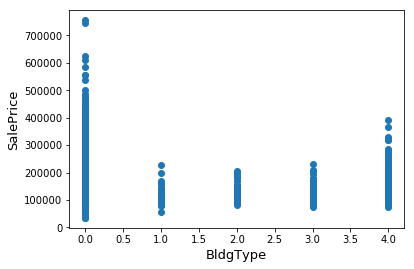

HouseStyle


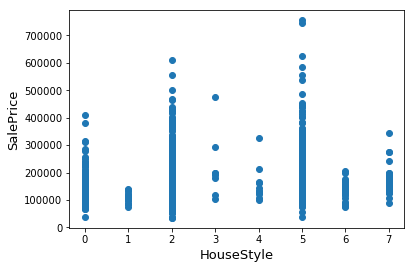

OverallQual


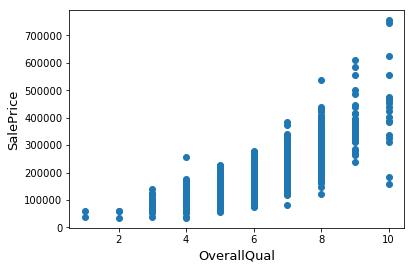

OverallCond


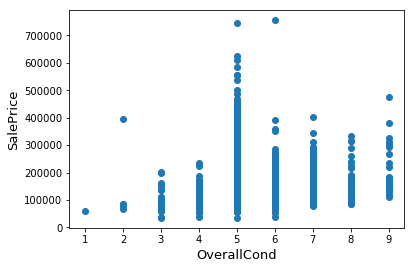

YearBuilt


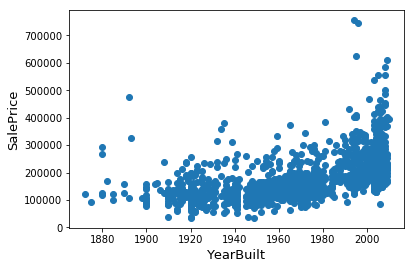

YearRemodAdd


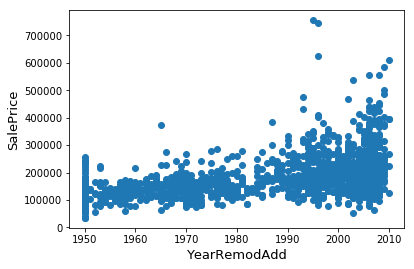

RoofStyle


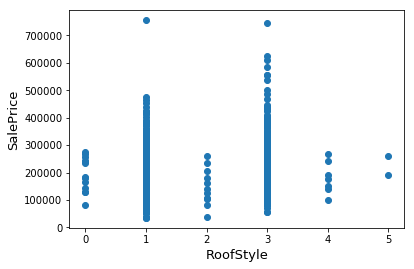

RoofMatl


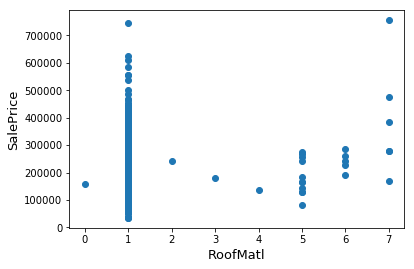

Exterior1st


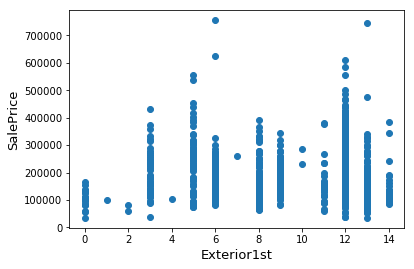

Exterior2nd


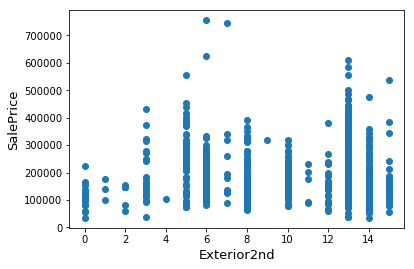

MasVnrType


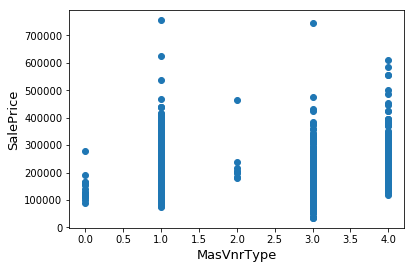

MasVnrArea


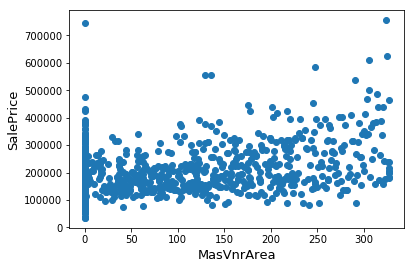

ExterQual


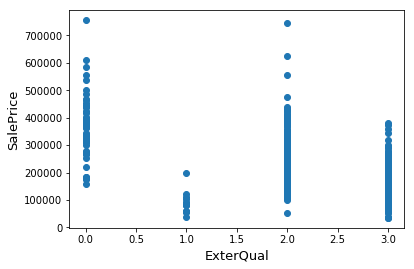

ExterCond


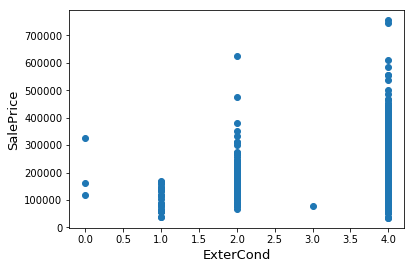

Foundation


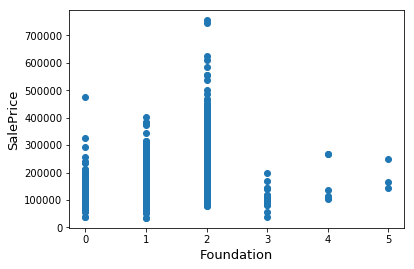

BsmtQual


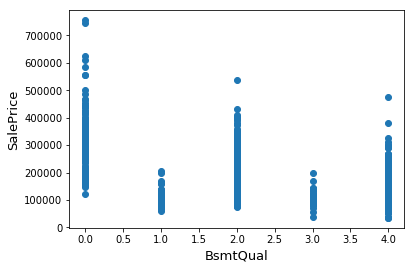

BsmtCond


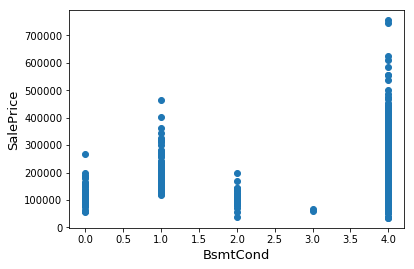

BsmtExposure


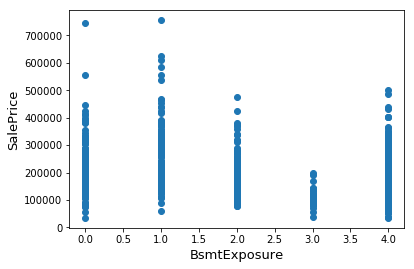

BsmtFinType1


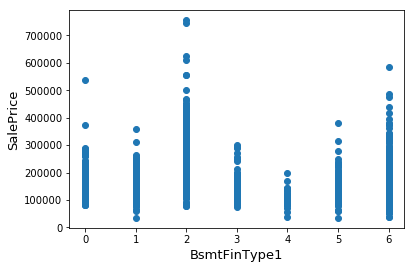

BsmtFinSF1


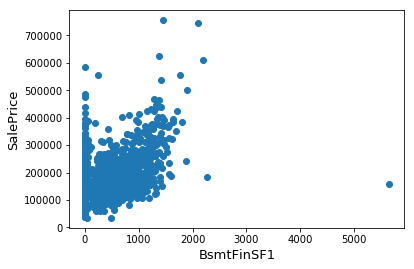

BsmtFinType2


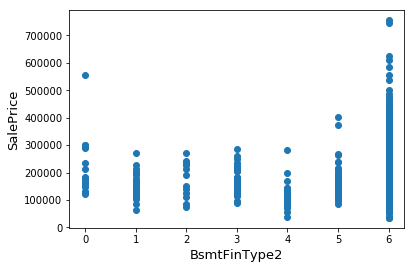

BsmtFinSF2


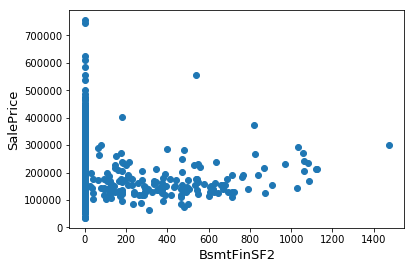

BsmtUnfSF


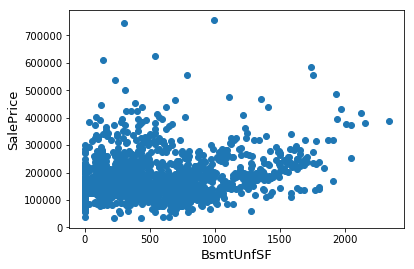

TotalBsmtSF


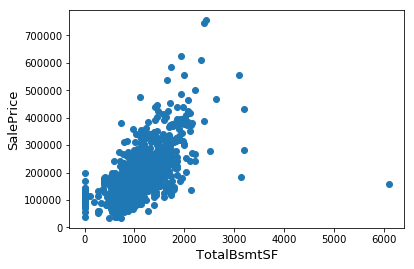

Heating


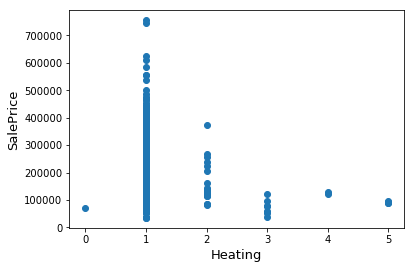

HeatingQC


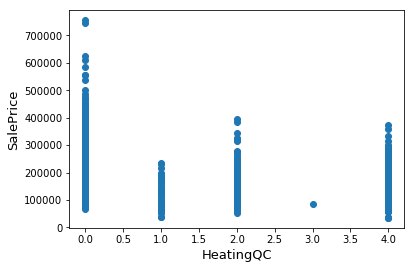

CentralAir


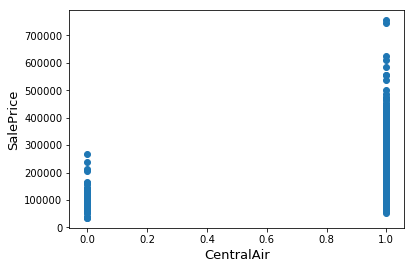

Electrical


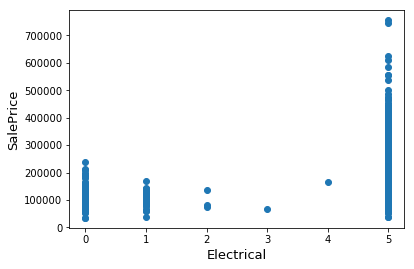

1stFlrSF


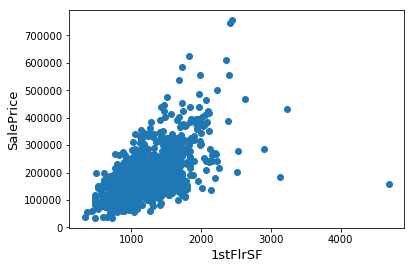

2ndFlrSF


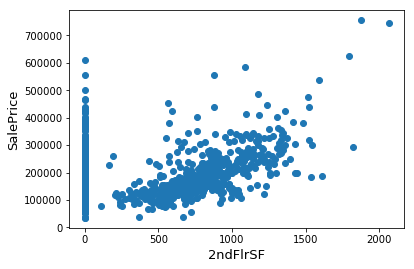

LowQualFinSF


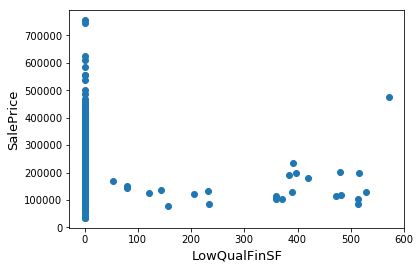

GrLivArea


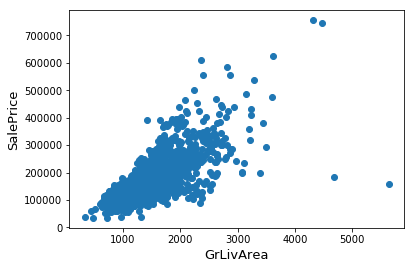

BsmtFullBath


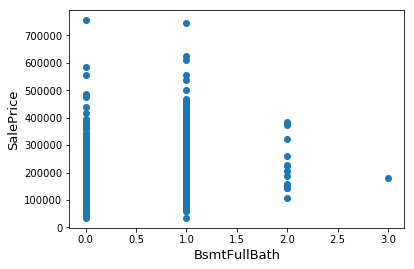

BsmtHalfBath


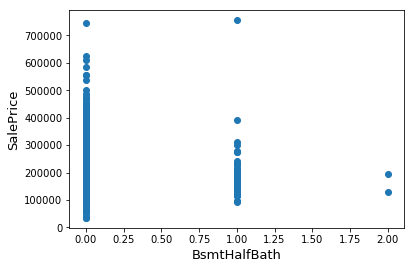

FullBath


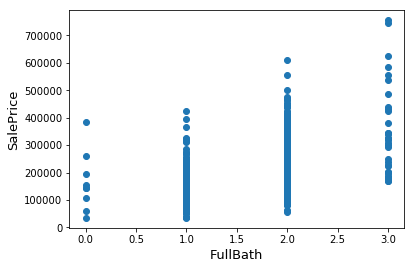

HalfBath


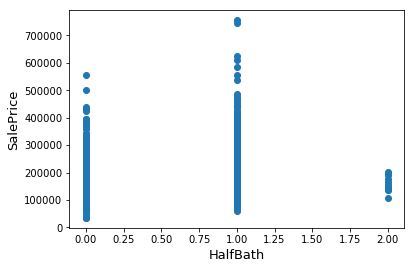

BedroomAbvGr


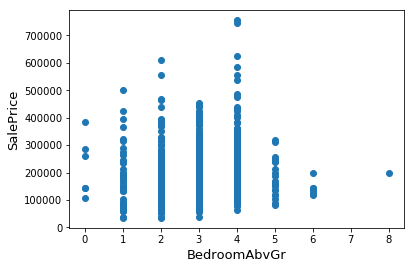

KitchenAbvGr


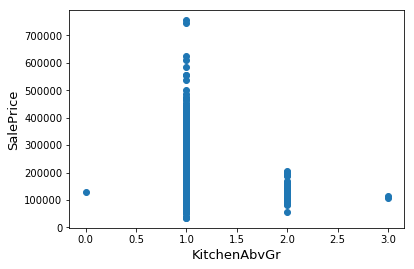

KitchenQual


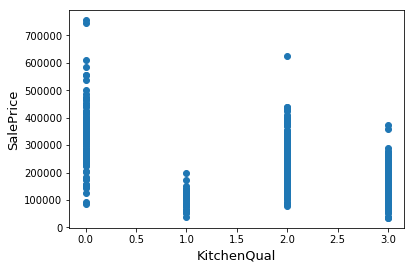

TotRmsAbvGrd


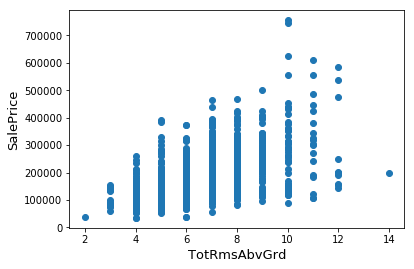

Functional


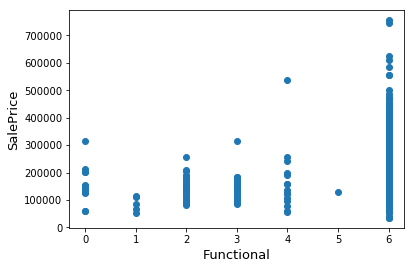

Fireplaces


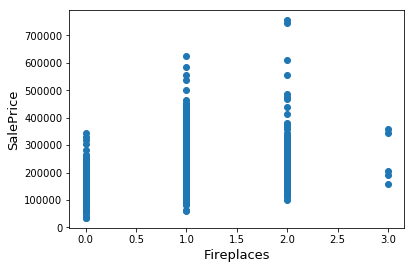

FireplaceQu


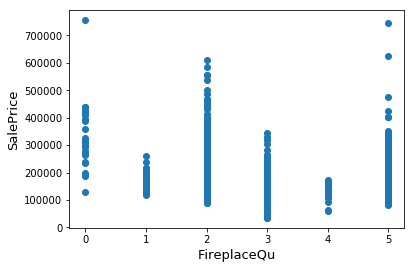

GarageType


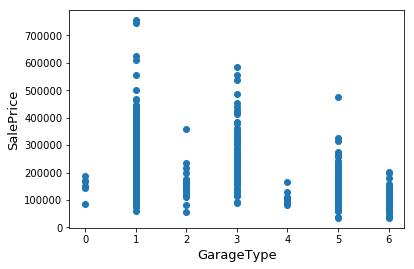

GarageYrBlt


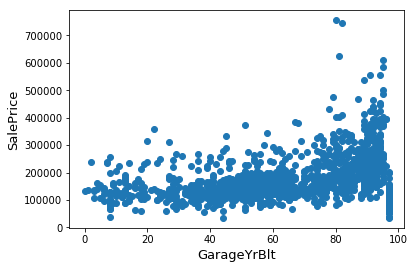

GarageFinish


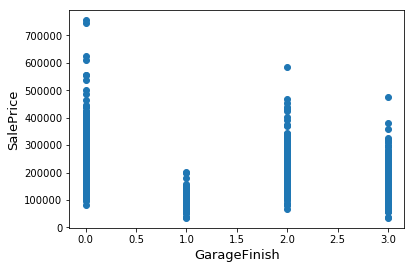

GarageCars


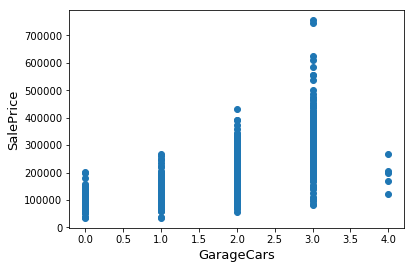

GarageArea


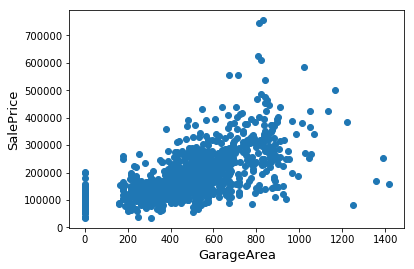

GarageQual


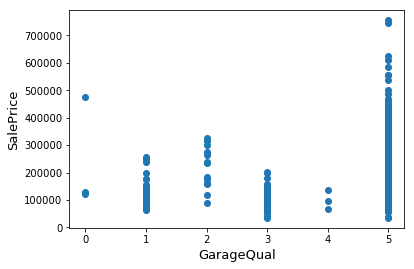

GarageCond


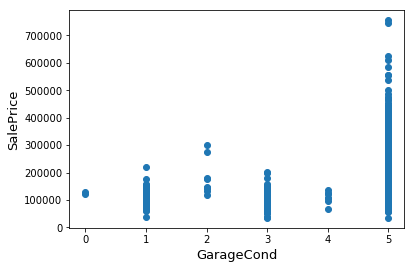

PavedDrive


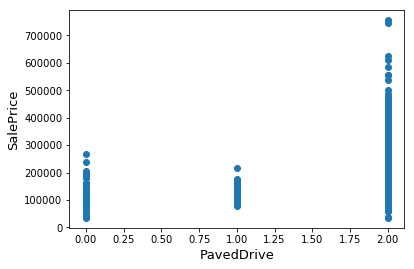

WoodDeckSF


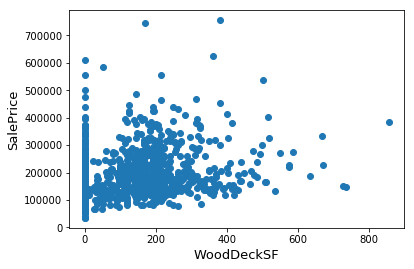

OpenPorchSF


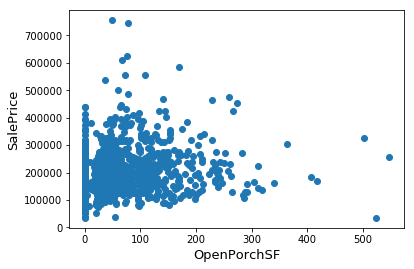

EnclosedPorch


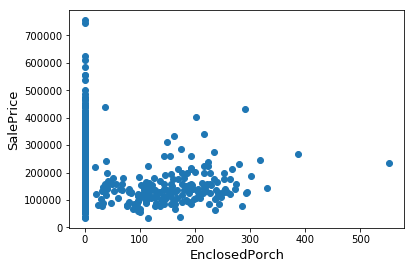

3SsnPorch


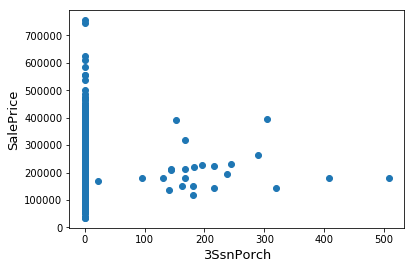

ScreenPorch


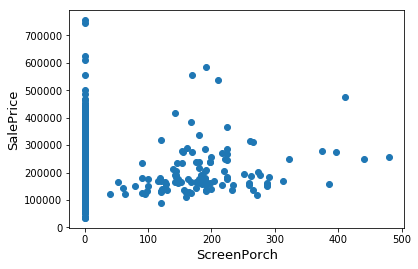

PoolArea


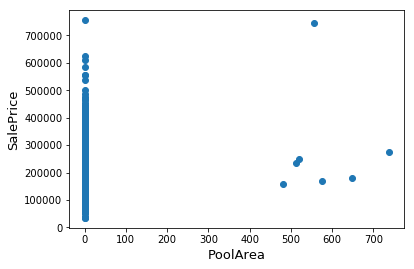

PoolQC


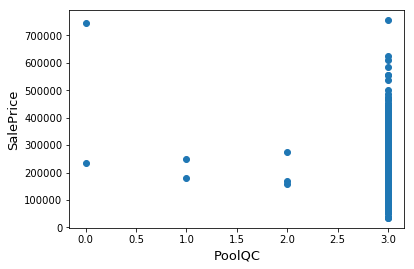

Fence


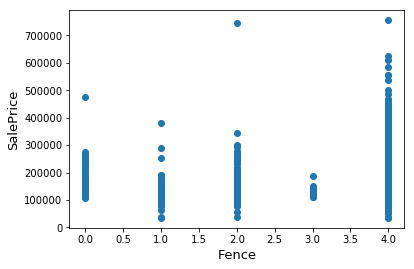

MiscFeature


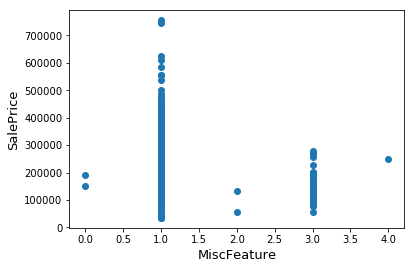

MiscVal


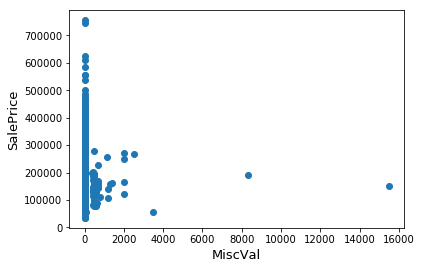

MoSold


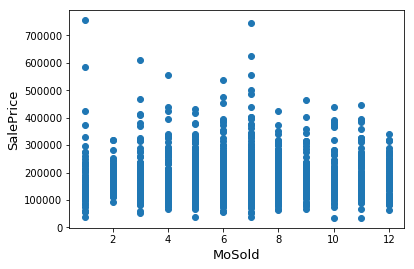

YrSold


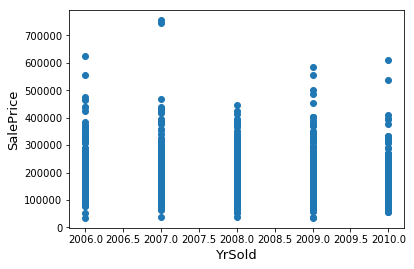

SaleType


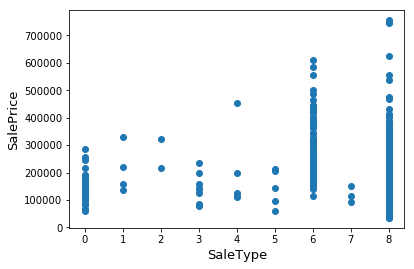

SaleCondition


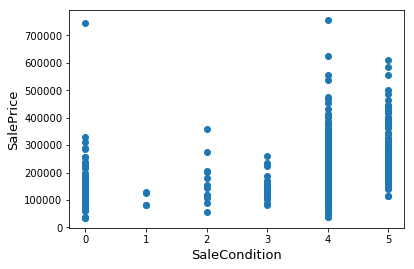

SalePrice


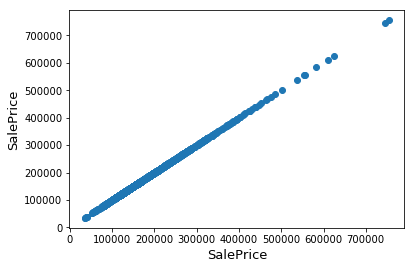

In [5]:
for i in Train_data.drop(columns=["Id"]).columns:
    print(i)
    fig, ax = plt.subplots()
    ax.scatter(x = Train_data[i], y = Train_data['SalePrice'])
    plt.ylabel('SalePrice', fontsize=13)
    plt.xlabel(i, fontsize=13)
    plt.show()



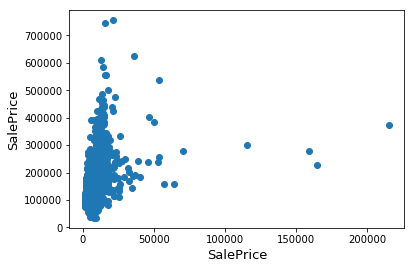

In [419]:
fig, ax = plt.subplots()
ax.scatter(x = Train_data["LotArea"], y = Train_data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(i, fontsize=13)
plt.show()

# removing outliers

In [265]:
mask = Train_data.LotArea > 200000
column_name = 'LotArea'
Train_data.loc[mask, column_name] = 150000

mask = Train_data.BsmtFinSF1 > 5000
column_name = 'BsmtFinSF1'
Train_data.loc[mask, column_name] = 2200

mask = Train_data.BsmtFinSF2 > 1200
column_name = 'BsmtFinSF2'
Train_data.loc[mask, column_name] = 1200

'''
mask = Train_data.1stFlrSF > 3500
column_name = '1stFlrSF'
Train_data.loc[mask, column_name] = 3200
'''
mask = Train_data.GarageYrBlt > 700000
column_name = 'GarageYrBlt'
Train_data.loc[mask, column_name] = 600000

mask = Train_data.EnclosedPorch > 500
column_name = 'EnclosedPorch'
Train_data.loc[mask, column_name] = 400
#Train_data.loc[Train_data["LotArea"]> 200000] = 150000
#Train_data.ix[Train_data["BsmtFinSF1"]> 5000] = 2200
#Train_data.ix[Train_data["BsmtFinSF2"]> 1200] = 1200
#Train_data.ix[Train_data["1stFlrSF"]> 3500] = 3200
#Train_data.ix[Train_data["GarageYrBlt"]> 700000] = 600000
#Train_data.ix[Train_data["EnclosedPorch"]> 500] = 400





In [266]:
#preparedData =  prepareData(data)


# Prepare train output

In [267]:
Train_data_y = data.values[:,data.shape[1]-1]

# Check if output data SalePrice is skewed

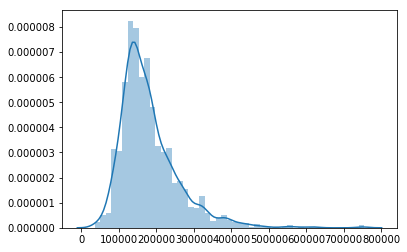

In [268]:
sns.distplot(Train_data_y.reshape(Train_data_y.shape[0],1) )

# Normalize data using box-cox transform

In [269]:
pt = PowerTransformer(method='box-cox',standardize=True)

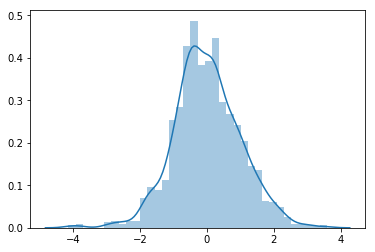

In [270]:

sns.distplot(power_transform(Train_data_y.reshape(Train_data_y.shape[0],1), method='box-cox',standardize=True))


In [271]:

#pwrTransfrmedData = pt.fit_transform(preparedData["SalePrice"].reshape(1460,1))
Train_data_y = pt.fit_transform(Train_data_y.reshape(Train_data_y.shape[0],1))


# fit to varience threshold on train data

In [272]:
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=(.8 * (1 - .8)))
varienceThresholdTrain = selector.fit(Train_data.drop(columns=["SalePrice","Id"])) 


In [273]:
Train_data = selector.transform(Train_data.drop(columns=["SalePrice","Id"]))

# transform varience threshold on test data

In [274]:
Test_data = varienceThresholdTrain.transform(Test_data.drop(columns=["Id"]))

In [275]:
Train_data.shape

(1460, 68)

In [276]:
Test_data.shape

(1459, 68)

In [277]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingRegressor

In [278]:
'''RMSerror = 1
bestCount = 0
for i in range(5,Train_data.shape[1]-1):
    chiTestModel = SelectKBest(score_func=chi2,k = i)
    X_train = chiTestModel.fit_transform(Train_data, data.values[:,data.shape[1]-1].astype('int'))
    y_train = data.values[:,data.shape[1]-1].reshape(1460,1)    
    
    scale_dataModel = scaler.fit(X_train)
    X_train = scale_dataModel.transform(X_train)
    y_train = scaler.fit_transform(y_train)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
    reg = RandomForestRegressor(n_estimators = 1000, random_state = 42,max_depth=6).fit(X_train, y_train)
   
    if(mean_squared_error(reg.predict(X_test),y_test) < RMSerror):
        bestCount = i
        RMSerror = mean_squared_error(reg.predict(X_test),y_test)
        print(i)
        print("TrainData RMS: ",mean_squared_error(reg.predict(X_train),y_train))
        print("TestData RMS: ",mean_squared_error(reg.predict(X_test),y_test))
'''   

'RMSerror = 1\nbestCount = 0\nfor i in range(5,Train_data.shape[1]-1):\n    chiTestModel = SelectKBest(score_func=chi2,k = i)\n    X_train = chiTestModel.fit_transform(Train_data, data.values[:,data.shape[1]-1].astype(\'int\'))\n    y_train = data.values[:,data.shape[1]-1].reshape(1460,1)    \n    \n    scale_dataModel = scaler.fit(X_train)\n    X_train = scale_dataModel.transform(X_train)\n    y_train = scaler.fit_transform(y_train)\n    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)\n    reg = RandomForestRegressor(n_estimators = 1000, random_state = 42,max_depth=6).fit(X_train, y_train)\n   \n    if(mean_squared_error(reg.predict(X_test),y_test) < RMSerror):\n        bestCount = i\n        RMSerror = mean_squared_error(reg.predict(X_test),y_test)\n        print(i)\n        print("TrainData RMS: ",mean_squared_error(reg.predict(X_train),y_train))\n        print("TestData RMS: ",mean_squared_error(reg.predict(X_test),y_test))\n'

In [279]:
scaler = MinMaxScaler(feature_range=(0, 1))

# selecting n best features which give us best prediction accuracy

In [422]:
RMSerror = 1
bestCount = 0
for i in range(Train_data.shape[1],40,-1):
   
    chiTestModel = SelectKBest(score_func=chi2,k = i)
    X_train = chiTestModel.fit_transform(Train_data, data.values[:,data.shape[1]-1].astype('int'))
    #estimator = SVR(kernel="linear")
    #selector = RFE(estimator, i, step=1)
    #X_train = selector.fit_transform(Train_data, data.values[:,data.shape[1]-1].astype('int'))
    y_train = Train_data_y  
    scale_dataModel = scaler.fit(X_train)
    X_train = scale_dataModel.transform(X_train)
    #pt = PowerTransformer(method='box-cox',standardize=True)
    #pwrTransfrmedData = pt.fit_transform(y_train)
    y_train = scaler.fit_transform(y_train)
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
    RFreg = RandomForestRegressor(n_estimators = 1000, random_state = 42,max_depth=9,min_samples_leaf=2,oob_score = True, n_jobs = -1).fit(X_train, y_train)
   
    #RFreg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000,max_depth=9, min_samples_leaf=2, subsample=0.8, random_state=10).fit(X_train, y_train)
    #RFreg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000,max_depth=None, subsample=0.8, random_state=10).fit(X_train, y_train)
    
    #print("RFreg: ",mean_squared_error(RFreg.predict(X_test),y_test))
    
    #print("GBRreg: ",mean_squared_error(GBRreg.predict(X_test),y_test))
   
    
    if(mean_squared_error(RFreg.predict(X_test),y_test) < RMSerror):
        bestCount = i
        RMSerror = mean_squared_error(RFreg.predict(X_test),y_test)
        #print(i)
        #print("TrainData RMS: ",mean_squared_error(RFreg.predict(X_train),y_train))
        #print("TestData RMS: ",mean_squared_error(RFreg.predict(X_test),y_test))
        

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to fl

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to fl

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [336]:
X_train.shape

(1168, 66)

In [337]:
X_test.shape

(292, 66)

In [338]:
Train_data.shape

(1460, 68)

In [404]:
chiTestModel = SelectKBest(score_func=chi2,k = bestCount)
X_train = chiTestModel.fit_transform(Train_data, data.values[:,data.shape[1]-1].astype('int'))
#estimator = SVR(kernel="linear")
#selector = RFE(estimator, 67, step=1)
#X_train = selector.fit_transform(X_train, y_train)

y_train = Train_data_y 
scalerTrain = MinMaxScaler(feature_range=(0, 1))
scale_dataModel = scalerTrain.fit(X_train)
X_train = scale_dataModel.transform(X_train)
scalerTrainY = MinMaxScaler(feature_range=(0, 1))
#pt = PowerTransformer(method='box-cox',standardize=True)
#pwrTransfrmedData = pt.fit_transform(preparedData["SalePrice"].reshape(1460,1))
y_train = scalerTrainY.fit_transform(y_train)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
RFreg = RandomForestRegressor(n_estimators = 1000, random_state = 42,max_depth=10,min_samples_leaf=4,oob_score = True, n_jobs = -1).fit(X_train, y_train)
#RFreg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000,max_depth=9, min_samples_leaf=2, subsample=0.8, random_state=10).fit(X_train, y_train)
#RFreg = linear_model.Ridge(alpha=.5).fit(X_train,y_train)

#GBRreg = GradientBoostingRegressor(learning_rate=0.1, n_estimators=1000,max_depth=9, min_samples_leaf=4, subsample=0.8, random_state=10).fit(X_train, y_train)
#LinReg = LinearRegression().fit(X_train, y_train)


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


In [405]:
X_test = chiTestModel.transform(Test_data)

In [406]:
X_test = scalerTrain.fit_transform(X_test)



/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [407]:
X_test.shape

(1459, 68)

In [408]:
mean_squared_error(RFreg.predict(X_train),y_train)


0.00079644252278542103

In [409]:
outputRF = scalerTrainY.inverse_transform(RFreg.predict(X_test).reshape(1459,1))
#outputGB = scalerTrainY.inverse_transform(GBRreg.predict(X_test).reshape(1459,1))
#outputLR = scalerTrainY.inverse_transform(LinReg.predict(X_test).reshape(1459,1))


In [410]:
outputRF[:,0].shape

(1459,)

In [411]:
dataset = pd.DataFrame({'SalePrice':pt.inverse_transform(outputRF[:,0].reshape(outputRF[:,0].shape[0],1))[:,0]})

In [412]:
pd.concat([data_test["Id"],dataset ], axis=1, join_axes=[dataset.index]).set_index(['Id']).to_csv(r'test_submission_V21.csv')
